In [7]:
from standardInclude import *

In [8]:
f = r.TFile("./pileupCorrection/NtriplePileupCorrected.root")
f.ls()

TFile**		./pileupCorrection/NtriplePileupCorrected.root	
 TFile*		./pileupCorrection/NtriplePileupCorrected.root	
  KEY: TCanvas	c1;1	c1


In [9]:
c = f.Get("c1")
print([x for x in c.GetListOfPrimitives()])

[<ROOT.TFrame object ("TFrame") at 0x7ffff3d5e3a0>, <ROOT.TH2D object ("NtriplePileup") at 0x7ffff3d76330>, <ROOT.TPaveText object ("title") at 0x7ffff4df2c30>]


In [10]:
Ninitial = c.GetPrimitive("NtriplePileup").Clone()
Ninitial.SetDirectory(0)

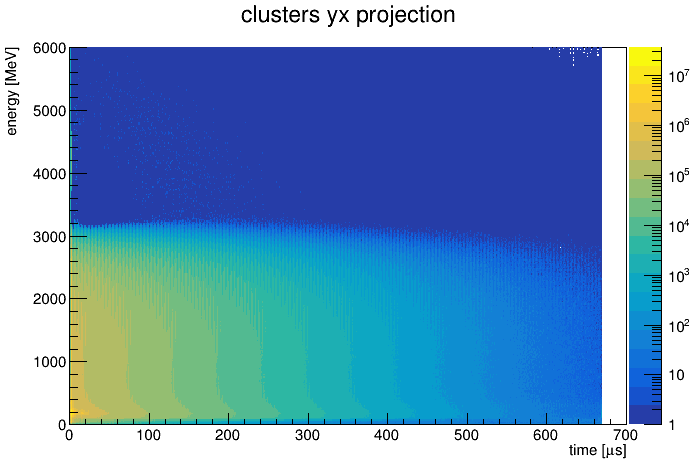

In [11]:
c = r.TCanvas()
Ninitial.Draw("colz")
c.SetLogz()
c.Draw()

---

# Pileup correction

### Lets follow the recipe outlined in Aaron's thesis, Page 175-180

In [12]:
# first define a function which takes a histogram and returns the quantity described in Eqn. 6.12
def rhoDoublePulse( hist, E, t ):
    timeBin = hist.GetXaxis().FindBin( t )
    h2 = hist.ProjectionY("h2", timeBin, timeBin)
    
    Nbins = h2.GetNbinsX() 
    Emin = h2.GetBinCenter(1) - h2.GetBinWidth(1)/2.0
    Emax = h2.GetBinCenter(Nbins) + h2.GetBinWidth(Nbins)/2.0
        
    rho = 0
    for bin in range(Nbins):
        E2 = h2.GetBinCenter(bin)
        if( E < E2 ):
            r1 = 0
        else:
            bin2 = h2.FindBin( E - E2 )
            r1 = h2.GetBinContent(bin2)
            
        r2 = h2.GetBinContent(bin)
        rho += r1*r2
        
    #print("Rho: ", rho)
    
    return rho;

In [13]:
#now build a histogram which has that function evaluated everywhere on the grid of our input histogram
rhoDoubleHist = Ninitial.Clone("rhoDoubleHist")
rhoDoubleHist.Reset()

In [14]:
nBinsX = rhoDoubleHist.GetXaxis().GetNbins()
nBinsY = rhoDoubleHist.GetYaxis().GetNbins()

for binx in range(1,nBinsX+1):
    print(binx,"/",nBinsX+1)
    for biny in range(1,nBinsY+1):
        Ei = rhoDoubleHist.GetYaxis().GetBinCenter(biny)
        ti = rhoDoubleHist.GetXaxis().GetBinCenter(binx)
        rhoi = rhoDoublePulse(Ninitial, Ei, ti)
        #print(rhoi)
        rhoDoubleHist.SetBinContent(binx,biny,rhoi)

1 / 4693
2 / 4693
3 / 4693
4 / 4693
5 / 4693
6 / 4693
7 / 4693
8 / 4693
9 / 4693
10 / 4693
11 / 4693
12 / 4693
13 / 4693
14 / 4693
15 / 4693
16 / 4693
17 / 4693
18 / 4693
19 / 4693
20 / 4693
21 / 4693
22 / 4693
23 / 4693
24 / 4693
25 / 4693
26 / 4693
27 / 4693
28 / 4693
29 / 4693
30 / 4693
31 / 4693
32 / 4693
33 / 4693
34 / 4693
35 / 4693
36 / 4693
37 / 4693
38 / 4693
39 / 4693
40 / 4693
41 / 4693
42 / 4693
43 / 4693
44 / 4693
45 / 4693
46 / 4693
47 / 4693
48 / 4693
49 / 4693
50 / 4693
51 / 4693
52 / 4693
53 / 4693
54 / 4693
55 / 4693
56 / 4693
57 / 4693
58 / 4693
59 / 4693
60 / 4693
61 / 4693
62 / 4693
63 / 4693
64 / 4693
65 / 4693
66 / 4693
67 / 4693
68 / 4693
69 / 4693
70 / 4693
71 / 4693
72 / 4693
73 / 4693
74 / 4693
75 / 4693
76 / 4693
77 / 4693
78 / 4693
79 / 4693
80 / 4693
81 / 4693
82 / 4693
83 / 4693
84 / 4693
85 / 4693
86 / 4693
87 / 4693
88 / 4693
89 / 4693
90 / 4693
91 / 4693
92 / 4693
93 / 4693
94 / 4693
95 / 4693
96 / 4693
97 / 4693
98 / 4693
99 / 4693
100 / 4693
101 / 46

In [15]:
c.Print("./pileupCorrection/rhoDoubleHist_secondRound.root")

Info in <TCanvas::SaveAs>: ROOT file ./pileupCorrection/rhoDoubleHist_secondRound.root has been created


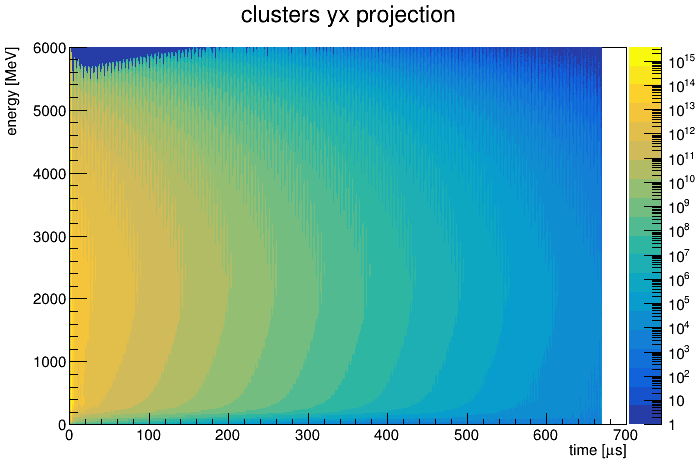

In [16]:
c = r.TCanvas()
rhoDoubleHist.Draw("colz")
c.SetLogz()
c.Draw()

### Now lets create a histogram built form equation 6.13 using the 6.12 histogram

In [17]:
doublePileup = Ninitial.Clone("doublePileup")
doublePileup.Reset()

In [18]:
deltaT = 2

In [19]:
def rhoDoublePileup(E, t, rhoDoubleHist, Ninitial, deltaT):
    histBinEtDouble = rhoDoubleHist.FindBin(t,E)
    histBinEtN = Ninitial.FindBin(t,E)
    histBintN = Ninitial.GetXaxis().FindBin(t)
    histBinEN = Ninitial.GetYaxis().FindBin(E)
    hi = Ninitial.ProjectionY("", histBintN, histBintN)
    integralN = hi.Integral(hi.FindBin(histBinEN),-1)
    rho = deltaT * ( rhoDoubleHist.GetBinContent(histBinEtDouble) - 2*Ninitial.GetBinContent(histBinEtN)*integralN )
    
    return rho

In [20]:
nBinsX = doublePileup.GetXaxis().GetNbins()
nBinsY = doublePileup.GetYaxis().GetNbins()

for binx in range(1,nBinsX+1):
    #if binx > 100:
    #    break
    print(binx,"/",nBinsX+1)
    for biny in range(1,nBinsY+1):
        Ei = doublePileup.GetYaxis().GetBinCenter(biny)
        ti = doublePileup.GetXaxis().GetBinCenter(binx)
        rhoi = rhoDoublePileup(Ei, ti, rhoDoubleHist, Ninitial, deltaT)
        #print(rhoi)
        doublePileup.SetBinContent(binx,biny,rhoi)

1 / 4693
2 / 4693
3 / 4693
4 / 4693
5 / 4693
6 / 4693
7 / 4693
8 / 4693
9 / 4693
10 / 4693
11 / 4693
12 / 4693
13 / 4693
14 / 4693
15 / 4693
16 / 4693
17 / 4693
18 / 4693
19 / 4693
20 / 4693
21 / 4693
22 / 4693
23 / 4693
24 / 4693
25 / 4693
26 / 4693
27 / 4693
28 / 4693
29 / 4693
30 / 4693
31 / 4693
32 / 4693
33 / 4693
34 / 4693
35 / 4693
36 / 4693
37 / 4693
38 / 4693
39 / 4693
40 / 4693
41 / 4693
42 / 4693
43 / 4693
44 / 4693
45 / 4693
46 / 4693
47 / 4693
48 / 4693
49 / 4693
50 / 4693
51 / 4693
52 / 4693
53 / 4693
54 / 4693
55 / 4693
56 / 4693
57 / 4693
58 / 4693
59 / 4693
60 / 4693
61 / 4693
62 / 4693
63 / 4693
64 / 4693
65 / 4693
66 / 4693
67 / 4693
68 / 4693
69 / 4693
70 / 4693
71 / 4693
72 / 4693
73 / 4693
74 / 4693
75 / 4693
76 / 4693
77 / 4693
78 / 4693
79 / 4693
80 / 4693
81 / 4693
82 / 4693
83 / 4693
84 / 4693
85 / 4693
86 / 4693
87 / 4693
88 / 4693
89 / 4693
90 / 4693
91 / 4693
92 / 4693
93 / 4693
94 / 4693
95 / 4693
96 / 4693
97 / 4693
98 / 4693
99 / 4693
100 / 4693
101 / 46

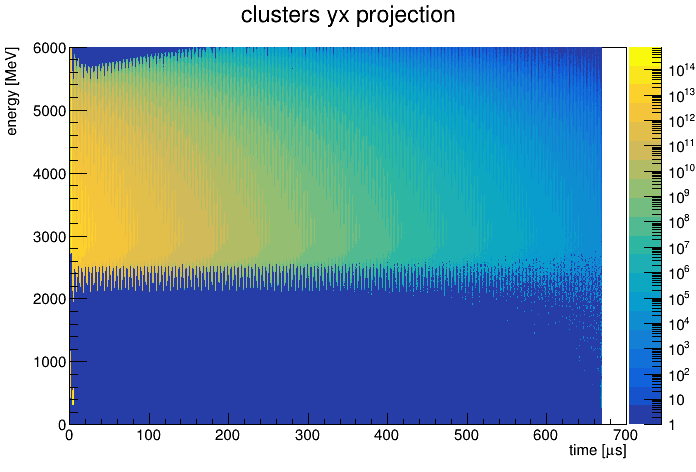

In [21]:
c = r.TCanvas()
doublePileup.Draw("colz")
c.SetLogz()
c.Draw()

In [22]:
c.Print("./pileupCorrection/doublePileup_secondRound.root")

Info in <TCanvas::SaveAs>: ROOT file ./pileupCorrection/doublePileup_secondRound.root has been created


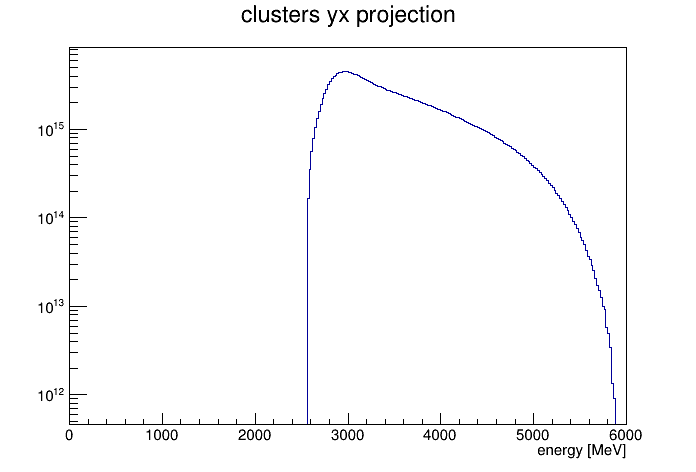

In [23]:
c = r.TCanvas()
doublePileup.ProjectionY().Draw("colz")
c.SetLogy()
c.Draw()

In [24]:
doublePileupInv = doublePileup.Clone("doublePileupInv")

nBinsX = doublePileupInv.GetXaxis().GetNbins()
nBinsY = doublePileupInv.GetYaxis().GetNbins()

for binx in range(1,nBinsX+1):
    #if binx > 100:
    #    break
    #print(binx,"/",nBinsX+1)
    for biny in range(1,nBinsY+1):
        doublePileupInv.SetBinContent(binx,biny,doublePileup.GetBinContent(binx,biny)*(-1))

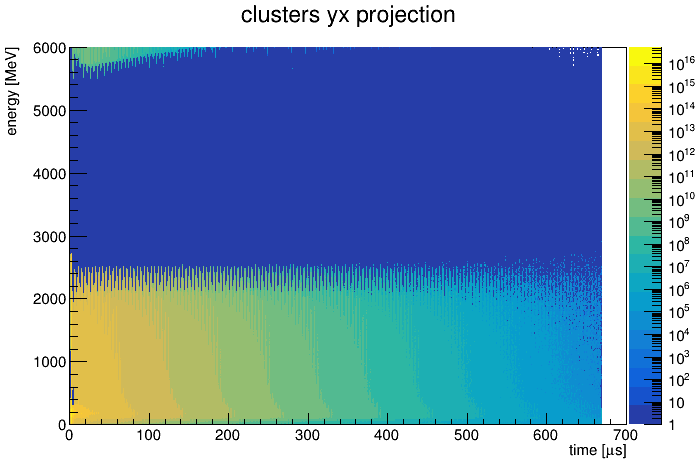

In [25]:
c = r.TCanvas()

doublePileupInv.Draw("colz")

c.SetLogz()
c.Draw()

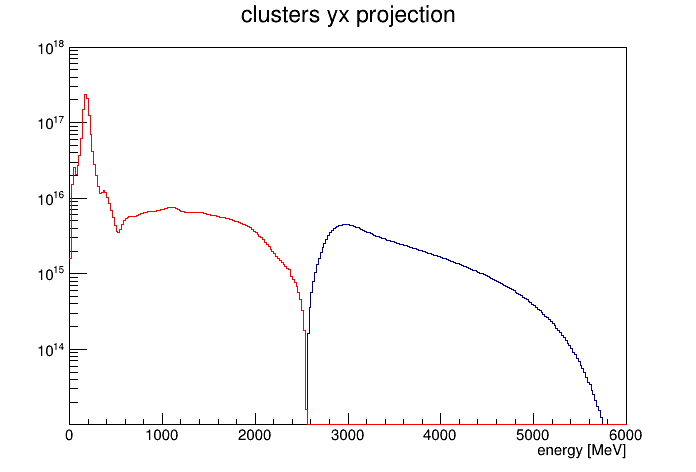

In [26]:
c = r.TCanvas()

doublePileupY = doublePileup.ProjectionY().Clone()
doublePileupY.Draw()
doublePileupY.GetYaxis().SetRangeUser(10**13,10**18)

doublePileupInv.SetLineColor(2)
doublePileupInv.ProjectionY().Draw("same")
c.SetLogy()
c.Draw()

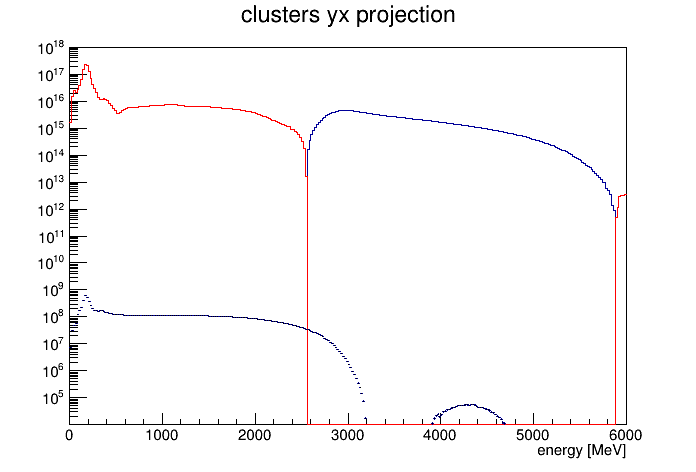

In [27]:
c = r.TCanvas()

doublePileupY = doublePileup.ProjectionY().Clone()
doublePileupY.Draw()
doublePileupY.GetYaxis().SetRangeUser(10**4,10**18)

doublePileupInv.SetLineColor(2)
doublePileupInv.ProjectionY().Draw("same")

Ninitial.ProjectionY().Draw("same")

c.SetLogy()
c.Draw()

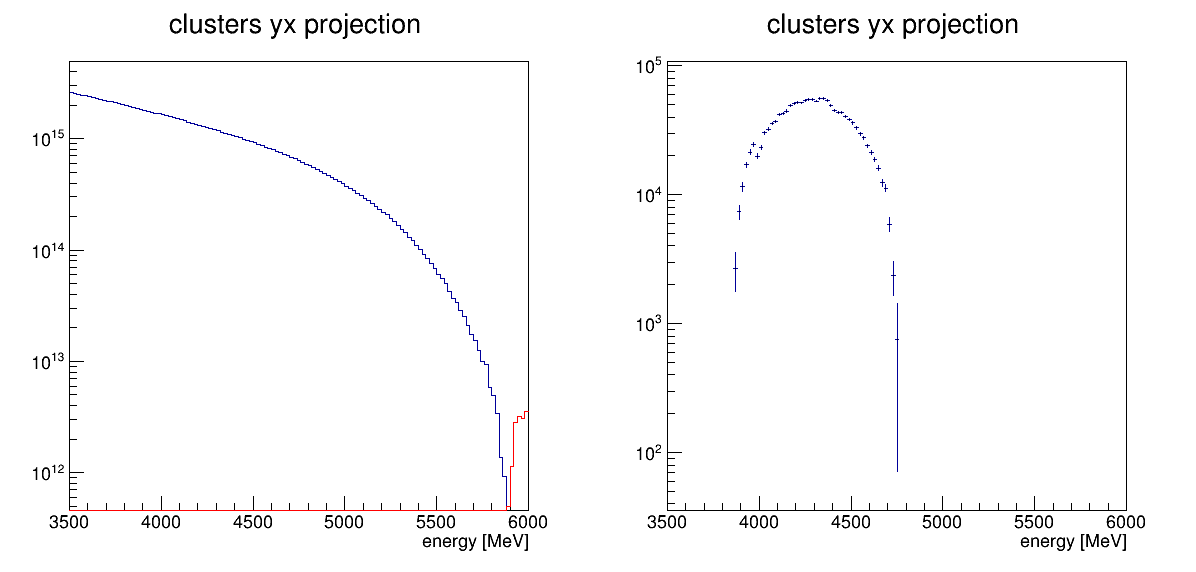

In [28]:
c = r.TCanvas("c","c",1200,600)
c.Divide(2)
c.cd(1)

doublePileupY.Draw()
doublePileupY.GetYaxis().UnZoom()
doublePileupY.GetXaxis().SetRangeUser(3500,6000)

doublePileupInv.SetLineColor(2)
doublePileupInv.ProjectionY().Draw("same")

r.gPad.SetLogy()

c.cd(2)

NinitialY = Ninitial.ProjectionY().Clone()
NinitialY.Draw("same")
NinitialY.GetXaxis().SetRangeUser(3500,6000)


r.gPad.SetLogy()
c.Draw()

---

### Now to fit the double pileup correction to N<sub>initial</sub> using the non-physical tail above 3.5 GeV

This is just a test to understand how to do it, the real pileup correction should fit the double and triple pileup simultainiously

In [29]:
# https://root.cern.ch/root/html/tutorials/fit/fithist.C.html
def fitHist(x, p):
    rawHist = doublePileupY
    scaleFactor = p[0]
    y = rawHist.GetBinContent( rawHist.FindBin(x[0]) ) * scaleFactor
    return y

In [30]:
doublePileupFit = r.TF1("doublePileupFit", fitHist, 3500, 6000, 1)
doublePileupFit.SetParameter(0,1)

In [31]:
NinitialY.Fit("doublePileupFit","REMBS")

 FCN=157963 FROM MINOS     STATUS=SUCCESSFUL      2 CALLS          36 TOTAL
                     EDM=2.09219e-15    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.12511e-12   6.81035e-14   6.81035e-14   9.49830e+05


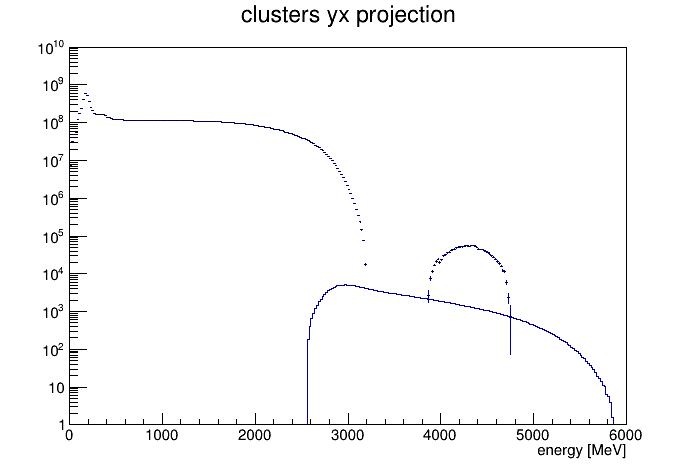

In [32]:
c = r.TCanvas()

doublePileupYScaled = doublePileupY.Clone()
doublePileupYScaled.Scale( doublePileupFit.GetParameter(0) )
doublePileupYScaled.GetXaxis().UnZoom()
doublePileupYScaled.GetYaxis().SetRangeUser(1,10**10)
doublePileupYScaled.Draw()

Ninitial.ProjectionY().Draw("same")

c.SetLogy()
c.Draw()

In [33]:
NdoubleSubtracted = Ninitial.ProjectionY().Clone()
NdoubleSubtracted.Add(doublePileupYScaled,-1)

True

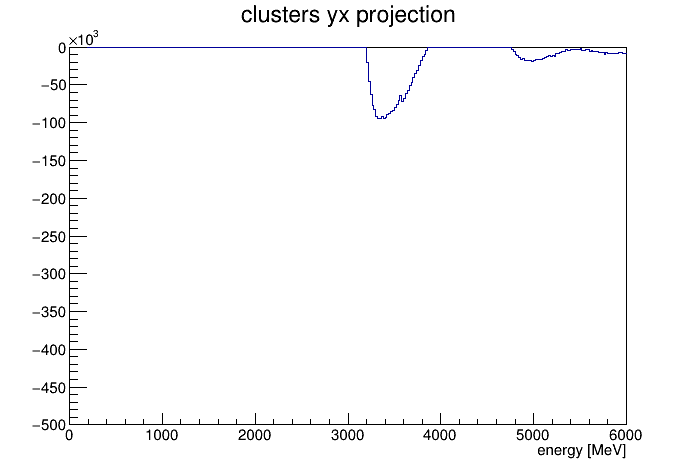

In [34]:
c = r.TCanvas()
NdoubleSubtracted.GetYaxis().SetRangeUser(-500000,0*10**10)
NdoubleSubtracted.Draw("hist")
#c.SetLogy()
c.Draw()

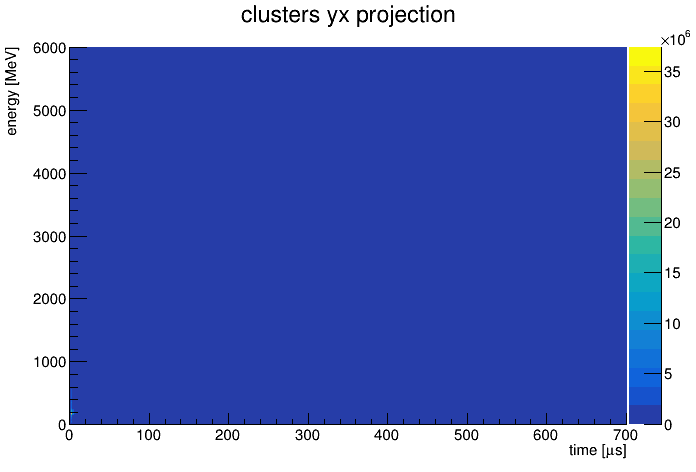

In [35]:
c = r.TCanvas()
NdoubleSubtracted = Ninitial.Clone("NdoubleSubtracted")
doublePileupScaled = doublePileup.Clone("doublePileupScaled")
doublePileupScaled.Scale(doublePileupFit.GetParameter(0))
NdoubleSubtracted.Add( doublePileupScaled, -1 )
NdoubleSubtracted.Draw("colz")
c.Draw()

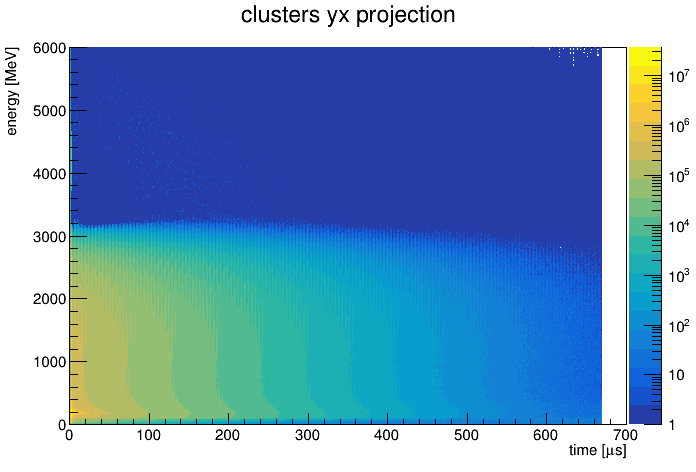

In [36]:
c = r.TCanvas()
NdoubleSubtracted.Draw("colz")
c.SetLogz()
c.Draw()

In [37]:
c.Print("./pileupCorrection/clustersPileupCorrected_DoubleOnly_secondRound.root")

Info in <TCanvas::SaveAs>: ROOT file ./pileupCorrection/clustersPileupCorrected_DoubleOnly_secondRound.root has been created


--- 

### And now lets go for gold and build the triple pileup correction (Eq. 6.15)

In [38]:
triplePileup = Ninitial.Clone("triplePileup")
triplePileup.Reset()

In [39]:
def rhoTriplePileup(E, t, rhoDoubleHist, Ninitial, deltaT):
    timeBinN = Ninitial.GetXaxis().FindBin( t )
    energySliceN = Ninitial.ProjectionY("", timeBinN, timeBinN).Clone()
    
    timeBinRho = rhoDoubleHist.GetXaxis().FindBin( t )
    energySliceRho = rhoDoubleHist.ProjectionY("", timeBinRho, timeBinRho).Clone()
    
    int1 = 0
    for bin1 in range( energySliceRho.GetNbinsX() ):
        Ed = energySliceRho.GetBinContent( bin1 )
        if( Ed > E ):
            int1 += 0
        else:
            rho1 = energySliceN.GetBinContent( energySliceN.GetXaxis().FindBin( E - Ed ) )
            rho2 = energySliceRho.GetBinContent( energySliceRho.GetXaxis().FindBin(Ed) )
            int1 += rho1*rho2
            #print(rho1,rho2)
        #print(int1)
    int2 = energySliceN.Integral()
    int3 = (int2)**2
    
    rhoDoubleEt = rhoDoubleHist.GetBinContent( rhoDoubleHist.GetXaxis().FindBin(t), rhoDoubleHist.GetYaxis().FindBin(E) )
    rhoEt = Ninitial.GetBinContent( Ninitial.GetXaxis().FindBin(t), Ninitial.GetYaxis().FindBin(E) )
    
    #print("***************************************")
    #print(int1,int2,int3)
    #print(rhoDoubleEt, rhoEt)
    #print(((deltaT)**2) * ( int1 ) )
    #print( int1 , - 3*rhoDoubleEt*int2 , 3*rhoEt*int3 )
    
    return ((deltaT)**2) * ( int1 - 3*rhoDoubleEt*int2 + 3*rhoEt*int3 )

In [40]:
for i in range(1,100,10):
    rhoTriplePileup(4000, i, rhoDoubleHist, Ninitial, deltaT)

In [41]:
nBinsX = triplePileup.GetXaxis().GetNbins()
nBinsY = triplePileup.GetYaxis().GetNbins()

for binx in range(1,nBinsX+1):
    #if binx > 10:
    #    break
    print(binx,"/",nBinsX+1)
    for biny in range(1,nBinsY+1):
        Ei = triplePileup.GetYaxis().GetBinCenter(biny)
        ti = triplePileup.GetXaxis().GetBinCenter(binx)
        rhoi = rhoTriplePileup(Ei, ti, rhoDoubleHist, Ninitial, deltaT)
        #print(rhoi)
        triplePileup.SetBinContent(binx,biny,rhoi)

1 / 4693
2 / 4693
3 / 4693
4 / 4693
5 / 4693
6 / 4693
7 / 4693
8 / 4693
9 / 4693
10 / 4693
11 / 4693
12 / 4693
13 / 4693
14 / 4693
15 / 4693
16 / 4693
17 / 4693
18 / 4693
19 / 4693
20 / 4693
21 / 4693
22 / 4693
23 / 4693
24 / 4693
25 / 4693
26 / 4693
27 / 4693
28 / 4693
29 / 4693
30 / 4693
31 / 4693
32 / 4693
33 / 4693
34 / 4693
35 / 4693
36 / 4693
37 / 4693
38 / 4693
39 / 4693
40 / 4693
41 / 4693
42 / 4693
43 / 4693
44 / 4693
45 / 4693
46 / 4693
47 / 4693
48 / 4693
49 / 4693
50 / 4693
51 / 4693
52 / 4693
53 / 4693
54 / 4693
55 / 4693
56 / 4693
57 / 4693
58 / 4693
59 / 4693
60 / 4693
61 / 4693
62 / 4693
63 / 4693
64 / 4693
65 / 4693
66 / 4693
67 / 4693
68 / 4693
69 / 4693
70 / 4693
71 / 4693
72 / 4693
73 / 4693
74 / 4693
75 / 4693
76 / 4693
77 / 4693
78 / 4693
79 / 4693
80 / 4693
81 / 4693
82 / 4693
83 / 4693
84 / 4693
85 / 4693
86 / 4693
87 / 4693
88 / 4693
89 / 4693
90 / 4693
91 / 4693
92 / 4693
93 / 4693
94 / 4693
95 / 4693
96 / 4693
97 / 4693
98 / 4693
99 / 4693
100 / 4693
101 / 46

In [42]:
c.Print("./pileupCorrection/triplePileup_Unscaled_secondRound.root")

Info in <TCanvas::SaveAs>: ROOT file ./pileupCorrection/triplePileup_Unscaled_secondRound.root has been created


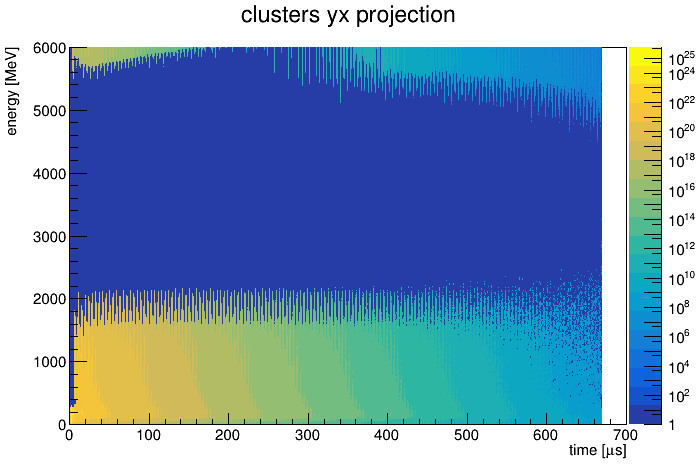

In [43]:
c = r.TCanvas()
triplePileup.Draw("colz")
c.SetLogz()
c.Draw()

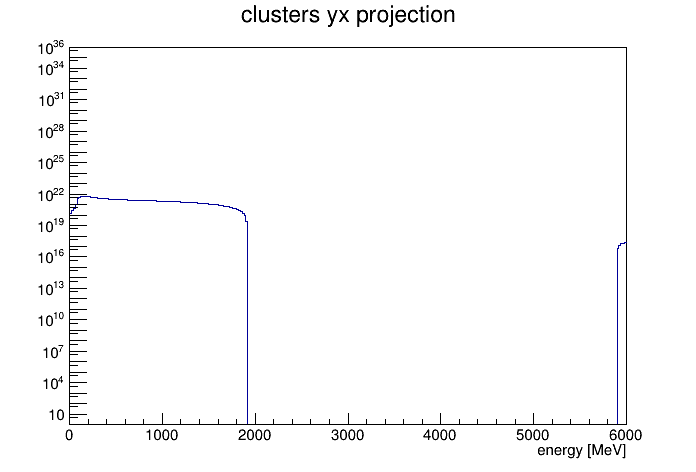

In [44]:
c = r.TCanvas()
triplePileupY = triplePileup.ProjectionY("",
                                        triplePileup.GetXaxis().FindBin(100),
                                        triplePileup.GetXaxis().FindBin(700)).Clone()
triplePileupY.GetYaxis().SetRangeUser(1,10**36)
triplePileupY.Draw()
c.SetLogy()
c.Draw()

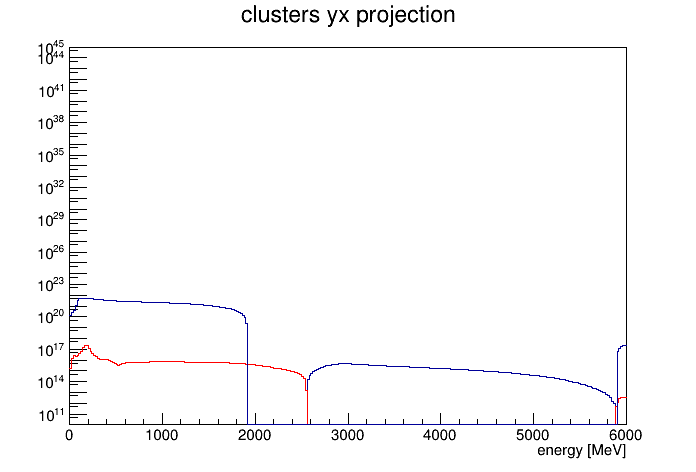

In [45]:
c = r.TCanvas()
doublePileupY.Draw()
doublePileupY.GetXaxis().SetRangeUser(0,6000)
doublePileupY.GetYaxis().SetRangeUser(10**10,10**45)
doublePileupInv.ProjectionY().Draw("same")
triplePileupY.Draw("same")
c.SetLogy()
c.Draw()

---

### And now fit to a linear combo of the double and triple pileup

In [46]:
# https://root.cern.ch/root/html/tutorials/fit/fithist.C.html
def fitHistTrip(x, p):
    rawHistDouble = doublePileupY
    rawHistTriple = triplePileupY
    scaleFactorDouble = p[0]
    scaleFactorTriple = p[1]
    y = ( rawHistDouble.GetBinContent( rawHistDouble.FindBin(x[0]) ) * scaleFactorDouble 
         + rawHistTriple.GetBinContent( rawHistTriple.FindBin(x[0]) ) * scaleFactorTriple )
    return y

In [62]:
triplePileupFit = r.TF1("triplePileupFit", fitHistTrip, 3500, 6000, 2)
triplePileupFit.SetParameters(1,-1)

In [63]:
for i in range(2):
    NinitialY.Fit("triplePileupFit","REMBS")

 FCN=147698 FROM MINOS     STATUS=SUCCESSFUL     10 CALLS         107 TOTAL
                     EDM=3.90246e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           4.79586e-11   4.67234e-13  -6.42373e-20   4.55460e+03
   2  p1           7.53634e-17   7.43834e-19   7.43834e-19  -7.15235e+09
 FCN=147698 FROM MINOS     STATUS=SUCCESSFUL     12 CALLS          71 TOTAL
                     EDM=3.81917e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           4.79586e-11   4.67235e-13   1.44928e-18   1.36638e+04
   2  p1           7.53634e-17   7.43835e-19   7.43835e-19  -2.14571e+09


In [64]:
doublePileupScaled = doublePileup.Clone("doublePileupScaled")
doublePileupScaled.Scale(triplePileupFit.GetParameter(0))

triplePileupScaled = triplePileup.Clone("triplePileupScaled")
triplePileupScaled.Scale(triplePileupFit.GetParameter(1))

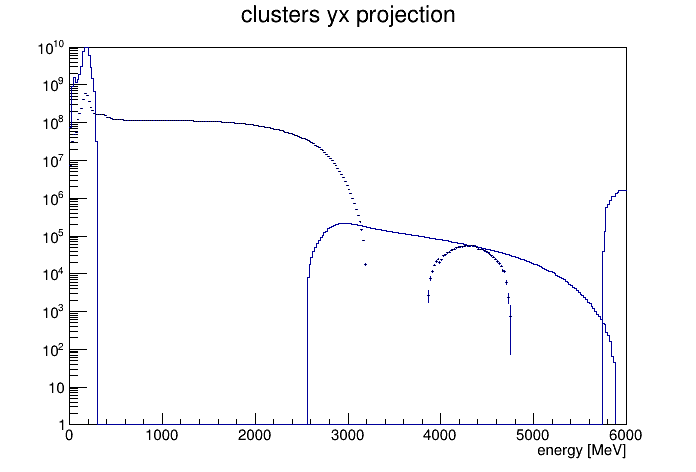

In [65]:
c = r.TCanvas()

doublePileupScaledY = doublePileupScaled.ProjectionY().Clone()
doublePileupScaledY.Draw("hist")
doublePileupScaledY.GetXaxis().SetRangeUser(0,6000)
doublePileupScaledY.GetYaxis().SetRangeUser(1,10**10)

triplePileupScaled.ProjectionY().Draw("hist same")

Ninitial.ProjectionY().Draw("SAME")

c.SetLogy()
c.Draw()

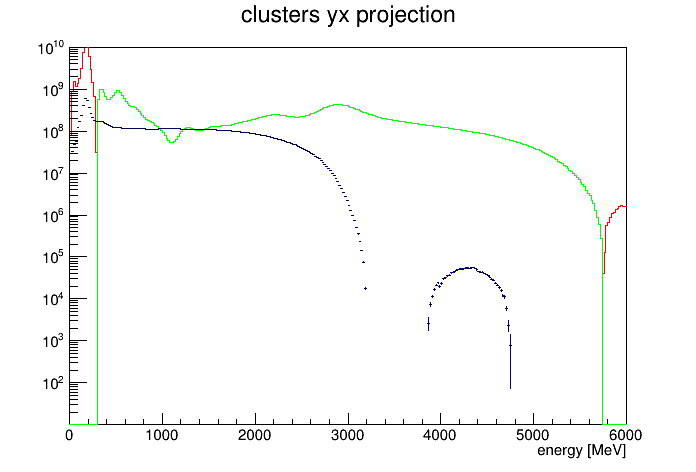

In [70]:
c = r.TCanvas()

totalPileupScaled = doublePileupScaledY.Clone()
totalPileupScaled.Add(triplePileupScaled.ProjectionY(),1)
totalPileupScaled.SetLineColor(2)
totalPileupScaled.Draw("hist")

totalPileupScaled.GetXaxis().SetRangeUser(0,6000)
totalPileupScaled.GetYaxis().SetRangeUser(10**1,10**10)

totalPileupScaledInv = totalPileupScaled.Clone("totalPileupScaledInv")
for i in range(totalPileupScaledInv.GetNbinsX()+1):
    totalPileupScaledInv.SetBinContent(i, totalPileupScaled.GetBinContent(i)*(-1))
totalPileupScaledInv.SetLineColor(3)
totalPileupScaledInv.Draw("hist same")

Ninitial.ProjectionY().Draw("SAME")

c.SetLogy()
c.Draw()

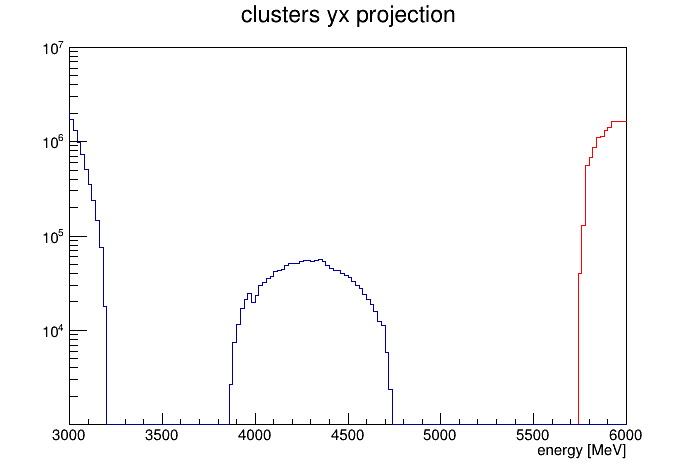

In [52]:
c = r.TCanvas()

totalPileupScaled.Draw("hist")

totalPileupScaled.GetXaxis().SetRangeUser(3000,6000)
totalPileupScaled.GetYaxis().SetRangeUser(10**3,10**7)

Ninitial.ProjectionY().Draw("hist SAME")

c.SetLogy()
c.Draw()

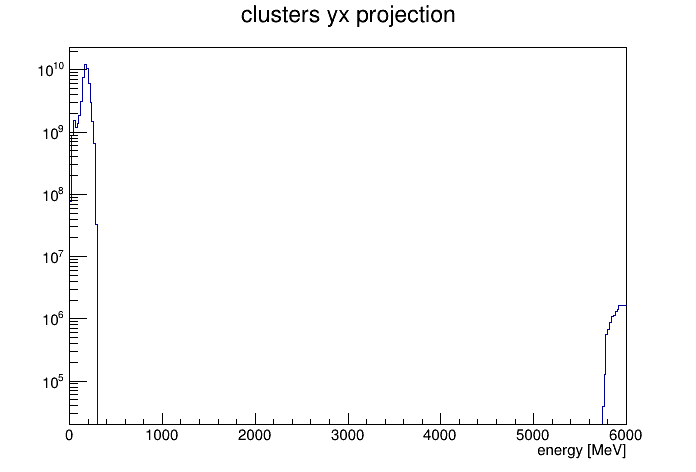

In [53]:
c = r.TCanvas()

triplePileupScaled.ProjectionY().Draw("hist ")

c.SetLogy()
c.Draw()

In [54]:
NtriplePileup = Ninitial.Clone("NtriplePileup")
NtriplePileup.Add(doublePileupScaled, -1)
NtriplePileup.Add(triplePileupScaled, -1)

True

Info in <TCanvas::SaveAs>: ROOT file ./pileupCorrection/NtriplePileupCorrected_secondRound.root has been created


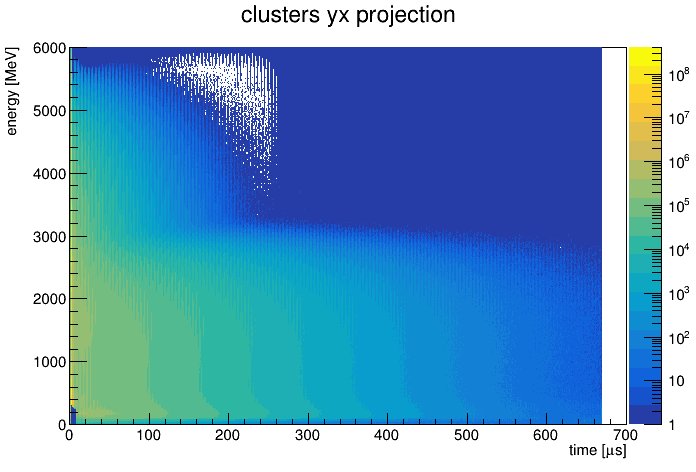

In [55]:
c = r.TCanvas()
NtriplePileup.Draw("colz")
c.SetLogz()
c.Draw()
c.Print("./pileupCorrection/NtriplePileupCorrected_secondRound.root")

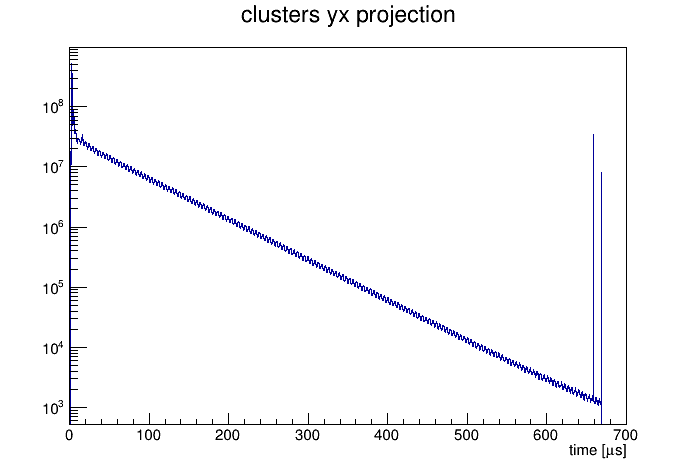

In [56]:
c = r.TCanvas()
NtriplePileup.ProjectionX().Draw("hist")
c.SetLogy()
c.Draw()

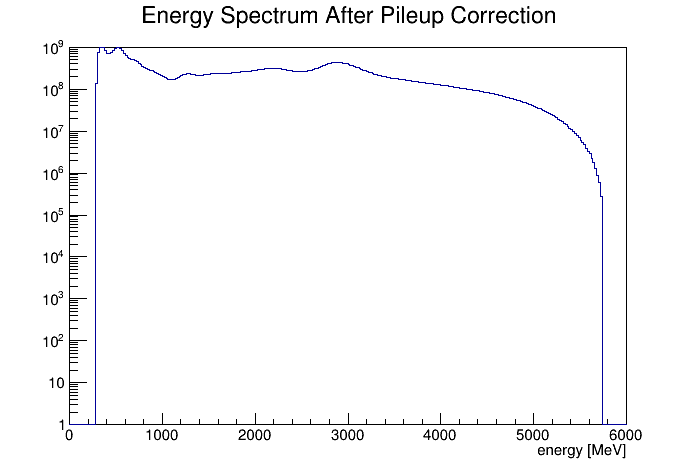

In [58]:
c = r.TCanvas()
NtriplePileupY = NtriplePileup.ProjectionY().Clone()
NtriplePileupY.SetTitle("Energy Spectrum After Pileup Correction")
NtriplePileupY.Draw("hist")
NtriplePileupY.GetXaxis().SetRangeUser(0,6000)
NtriplePileupY.GetYaxis().SetRangeUser(1,10**9)
NtriplePileupInv.Draw("hist same")
c.SetLogy()
c.Draw()

In [59]:
NtriplePileupInv = NtriplePileup.ProjectionY().Clone()
for i in range(NtriplePileupInv.GetNbinsX()):
    NtriplePileupInv.SetBinContent(i, NtriplePileupY.GetBinContent(i)*(-1))
NtriplePileupInv.SetLineColor(2)

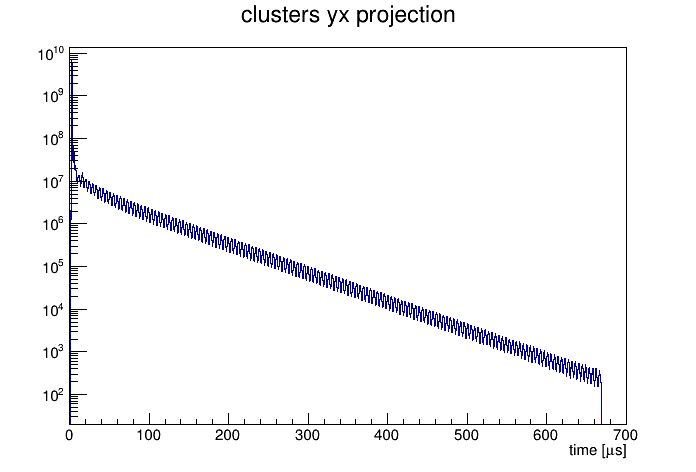

In [60]:
c = r.TCanvas()
binLow = NtriplePileup.GetYaxis().FindBin(1700)
binHigh = NtriplePileup.GetYaxis().FindBin(3300)
NtriplePileup.ProjectionX("",binLow,binHigh).Draw("hist")
c.SetLogy()
c.Draw()

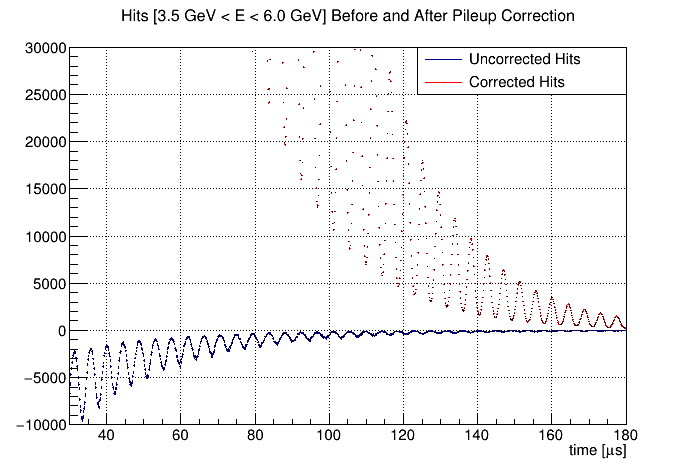

In [61]:
c = r.TCanvas()
correctedWiggle = NtriplePileup.ProjectionX("",
                                           NtriplePileup.GetYaxis().FindBin(3500),
                                           NtriplePileup.GetYaxis().FindBin(6000)).Clone("correctedWiggle")
uncorrectedWiggle = Ninitial.ProjectionX("",
                                           Ninitial.GetYaxis().FindBin(3500),
                                           Ninitial.GetYaxis().FindBin(6000)).Clone("uncorrectedWiggle")
correctedWiggle.SetLineColor(2)
uncorrectedWiggle.SetTitle("Hits [3.5 GeV < E < 6.0 GeV] Before and After Pileup Correction")

uncorrectedWiggle.GetYaxis().SetRangeUser(-10000,30000)
uncorrectedWiggle.GetXaxis().SetRangeUser(30,180)
uncorrectedWiggle.Draw()

correctedWiggle.Draw("SAME")

leg = r.TLegend(0.6,0.8,0.9,0.9)
leg.AddEntry(uncorrectedWiggle,"Uncorrected Hits")
leg.AddEntry(correctedWiggle,"Corrected Hits")
leg.Draw("SAME")

c.SetGrid()

c.Draw()